<a href="https://colab.research.google.com/github/narc01eptic/vmsk-2021/blob/main/ecg_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка необходимых зависимостей и данных


## Импорты

In [ ]:
!pip install joblib torch deap update_checker stopit xgboost tpot neurokit2 pyhrv

In [409]:
import pandas as pd
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import neurokit2 as nk
import pyhrv.frequency_domain as fd
from tqdm.notebook import tqdm as tqdm
from scipy import signal, stats
from sklearn.model_selection import train_test_split

## Данные

ЭКГ пациентов

In [ ]:
!mkdir /content/ecg
!gdown -O /content/ecg/PX113190416115700_full_ch_1.txt https://drive.google.com/uc?id=17-TYDv3xGtL_0LXe_jjWjKFXqyaGfs6Q
!gdown -O /content/ecg/PX113190529165727_full_ch_1.txt https://drive.google.com/uc?id=1vnYBjDMyuj-MH2MUTMpmc55-g3--_51n
!gdown -O /content/ecg/PX458190315162821_full_ch_1.txt https://drive.google.com/uc?id=1WMprHbxzROm4ez9HiNnKRuyqcGTE3kDT

In [2]:
ecg_PX113190416115700 = "/content/ecg/PX113190416115700_full_ch_1.txt"
ecg_PX113190529165727 = "/content/ecg/PX113190529165727_full_ch_1.txt"
ecg_PX458190315162821 = "/content/ecg/PX458190315162821_full_ch_1.txt"

Размеченные датасеты ЭКГ

In [ ]:
!gdown -O /content/dataset/dataframe_hrv.csv https://drive.google.com/uc?id=1F7wSWg56mb2d57yfU5HZIYnX6V-gHkCB

In [ ]:
!gdown -O /content/dataset/dftest.csv https://drive.google.com/uc?id=1crRGacxqxTL_GxZ2XWu_Fx-oCxOQRmh3

Классификатор

In [ ]:
!gdown -O /content/KNN_classifier.pickle https://drive.google.com/uc?id=1LBuLjdOrXCl2HEtBE-NfhgfH3fQlXBBd
!gdown -O /content/KNN_classifier2.pickle https://drive.google.com/uc?id=1SYuQggBgBBDHtxme3oNVc-Vfc6t-LqOP

In [46]:
classifier = pickle.load(open("/content/KNN_classifier2.pickle", 'rb'))
classifier_old = pickle.load(open("/content/KNN_classifier.pickle", 'rb'))

# Обучение классификатора

In [126]:
def fix_stress_labels(df='',label_column='stress'):
    df['stress'] = np.where(df['stress']>=0.5, 1, 0)
    return df

def missing_values(df, hr = False):
    df = df.reset_index()
    df = df.replace([np.inf, -np.inf], np.nan)
    df[~np.isfinite(df)] = np.nan
    if hr:
      df['HR'].fillna((df['HR'].mean()), inplace=True)
      df['HR'] = signal.medfilt(df['HR'],13) 
    df.fillna(df.mean(),inplace=True)
    return df

In [196]:
dataframe_hrv = pd.read_csv("/content/dataset/dataframe_hrv.csv")
dataframe_hrv = dataframe_hrv.reset_index(drop=True)
dataframe_hrv = fix_stress_labels(df=dataframe_hrv)
dataframe_hrv = missing_values(dataframe_hrv, True)
dataframe_hrv.rename(columns={"interval in seconds": "RR"}, inplace = True)
selected_x_columns = ['HR','RR','AVNN', 'RMSSD', 'pNN50', 'TP', 'ULF', 'VLF', 'LF', 'HF','LF_HF']

dataframe_hrv.head()

,index,ECG,EMG,HR,RESP,Seconds,footGSR,handGSR,RR,marker,newtime,stress,time,NNRR,AVNN,SDNN,RMSSD,pNN50,TP,ULF,VLF,LF,HF,LF_HF
0,0,-0.001974,-0.004737,77.815789,10.801842,12.529684,2.417132,10.889447,0.614632,12.05703,12.529684,0,12.529684,0.973684,0.617297,3.558630e-02,0.015203,0.055556,0.001238,0.0,0.000696,0.000407,0.000135,3.002000
1,1,0.002935,-0.004457,79.521739,10.750609,30.503500,2.417109,11.251065,0.647826,12.05703,30.503500,0,30.503500,0.978261,0.647889,1.354660e-02,0.013858,0.045455,0.000144,0.0,0.000009,0.000060,0.000075,0.793710
2,2,0.006745,-0.003426,87.319149,10.557234,52.523021,2.226872,11.379638,0.646383,12.05703,52.523021,0,52.523021,0.978723,0.645000,2.240000e-08,0.000000,0.000000,0.060604,0.0,0.000728,0.000003,0.000001,3.555695
3,3,-0.004043,-0.002532,87.702128,10.640128,74.402170,2.173021,11.470830,0.645000,12.05703,74.402170,0,74.402170,0.978723,0.645000,2.240000e-08,0.000000,0.000000,0.060604,0.0,0.000728,0.000003,0.000001,3.555695
4,4,0.012745,-0.004426,87.702128,10.699319,96.219617,2.017106,11.135255,0.645000,12.05703,96.219617,0,96.219617,0.978723,0.645000,2.240000e-08,0.000000,0.000000,0.060604,0.0,0.000728,0.000003,0.000001,3.555695


In [197]:
X = dataframe_hrv[selected_x_columns]
y = dataframe_hrv['stress']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 1)

In [198]:
from tpot import TPOTClassifier
def do_tpot(generations=10, population_size=10, X='', y=''):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

    tpot = TPOTClassifier(generations=generations, population_size=population_size, verbosity=2,cv=3)
    tpot.fit(X_train, y_train)
    print(tpot.score(X_test, y_test))
    tpot.export('tpot_pipeline.py')
    return tpot

tpot_classifer = do_tpot(generations=5, population_size=5, X=X, y=y)


Generation 1 - Current best internal CV score: 0.8486224644262791

Generation 2 - Current best internal CV score: 0.8489252194974265

Generation 3 - Current best internal CV score: 0.8531637904934909

Generation 4 - Current best internal CV score: 0.8546775658492279

Generation 5 - Current best internal CV score: 0.8607326672721768

Best pipeline: RandomForestClassifier(Normalizer(input_matrix, norm=l1), bootstrap=False, criterion=gini, max_features=0.6500000000000001, min_samples_leaf=4, min_samples_split=9, n_estimators=100)
0.8837772397094431


In [200]:
!mkdir /content/train

In [201]:
pickle.dump(tpot_classifer.fitted_pipeline_, open("/content/train/RF_classifier.pickle", 'wb'))

# Проверка на тестовом датасете

## Функции обработки сигнала

In [156]:
def plotReading(dfnewHRV, dfpred, title = None):
    dfnewHRV["stress"] = dfpred["stress"]
    # dfnewHRV.loc[dfnewHRV["steps"] > 0, 'stress'] = np.nan
    #mark is to mark the RR peaks as stress
    dfnewHRV.loc[dfnewHRV["stress"] == 1, 'stress'] = dfnewHRV['RR'] 
    # dfnewHRV.loc[dfnewHRV["steps"] > 0, 'moving'] = dfnewHRV['interval in seconds'] 
    dfnewHRV["minutes"] = (dfnewHRV['newtime']/60)/1000
    
    from itertools import cycle, islice
    my_colors = list(islice(['b', 'r'], 0, len(dfnewHRV)))
    plot = dfnewHRV.plot(x="minutes", y=['RR',"stress"],color=my_colors,figsize=(13, 7), title = title)

In [98]:
def runClassifier(df, predictor, selected_x_columns):
  df = missing_values(df)
  dfnew = df[selected_x_columns].fillna(0)
  pred = predictor.predict_proba(dfnew)
  dfpred = pd.DataFrame(pred)
  dfpred.columns = ["FALSE","TRUE"]
  dfpred['stress'] = np.array(np.where(dfpred["TRUE"] > 0.5, 1, np.nan))

  return dfpred

In [151]:
def runAlgorithm(df, selected_x_columns):
  df = missing_values(df)
  dfnew = df[selected_x_columns].fillna(0)
  stress = []
  for index, row in dfnew.iterrows():
    s = 0
    if not (60 < row["HR"] < 90): s += 1
    if not (568 < row["HF"] < 768) and (row["HF"] != 0.): s += 1
    if not (995 < row["LF"] < 1345) and (row["LF"] != 0.): s += 1
    if not (1077 < row["VLF"] < 1458) and (row["VLF"] != 0.): s += 1
    if not (2640 < row["TP"] * 1E6 < 3571): s += 1
    if not (1.5 < row["LF_HF"] < 1.8) and (row["LF_HF"] != 0.): s += 1
    if s >= 2: stress.append(1)
    else: stress.append(np.nan)

  dfpred = pd.DataFrame(stress, columns = ["stress"])
  return dfpred

## Загрузка и анализ сигнала

In [157]:
input_df = pd.read_csv('/content/dataset/dftest.csv')
input_df.rename(columns={"interval in seconds": "RR"}, inplace = True)

In [158]:
input_df.head()

,calories,distance,floors,heart,RR,newtime,nntime,rrmedfilt,steps,NNRR,AVNN,SDNN,RMSSD,pNN50,TP,ULF,VLF,LF,HF,LF_HF,HR
0,1.260461,0.0,0.0,62.333333,0.942926,11926.370370,11926.370370,931.407407,0.0,0.962963,0.941846,0.104229,0.104013,0.400000,0.011699,0.011699,0.0,0.0,0.0,NaN,62.333333
1,1.198738,0.0,0.0,60.750000,0.956667,27722.277778,27722.277778,953.388889,0.0,0.972222,0.960771,0.088014,0.083233,0.411765,0.007722,0.007722,0.0,0.0,0.0,NaN,60.750000
2,1.169500,0.0,0.0,60.000000,0.949189,48151.297297,48151.297297,942.216216,0.0,0.972973,0.949556,0.086657,0.077849,0.457143,0.007349,0.007349,0.0,0.0,0.0,NaN,60.000000
3,1.169500,0.0,0.0,60.444444,0.980806,68824.527778,68824.527778,971.638889,0.0,0.972222,0.981400,0.051475,0.053796,0.352941,0.002538,0.002538,0.0,0.0,0.0,NaN,60.444444
4,1.169500,0.0,0.0,61.611111,0.980944,89413.305556,89413.305556,974.638889,0.0,0.972222,0.979857,0.052628,0.050855,0.264706,0.002618,0.002618,0.0,0.0,0.0,NaN,61.611111


In [159]:
selected_x_columns = ['HR','RR','AVNN', 'RMSSD', 'pNN50', 'TP', 'ULF', 'VLF', 'LF', 'HF','LF_HF']
dfpredClassifier = runClassifier(input_df, classifier, selected_x_columns)

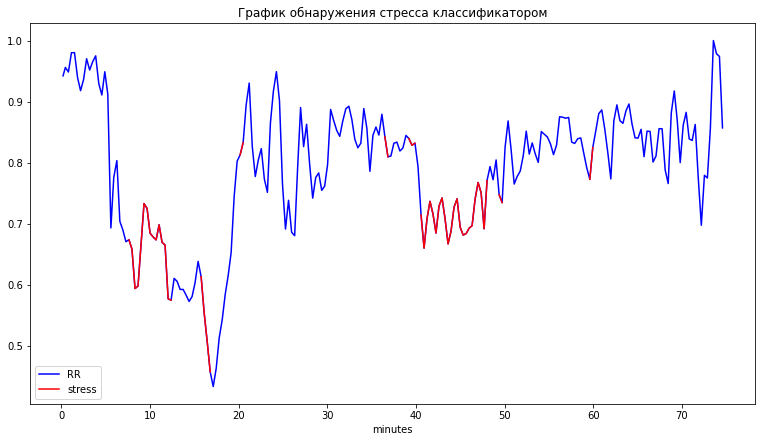

In [161]:
plotReading(input_df, dfpredClassifier, "График обнаружения стресса классификатором")

In [154]:
selected_x_columns = ['HR','RR','AVNN', 'RMSSD', 'pNN50', 'TP', 'ULF', 'VLF', 'LF', 'HF','LF_HF']
dfpredAlgorithm = runAlgorithm(input_df, selected_x_columns)

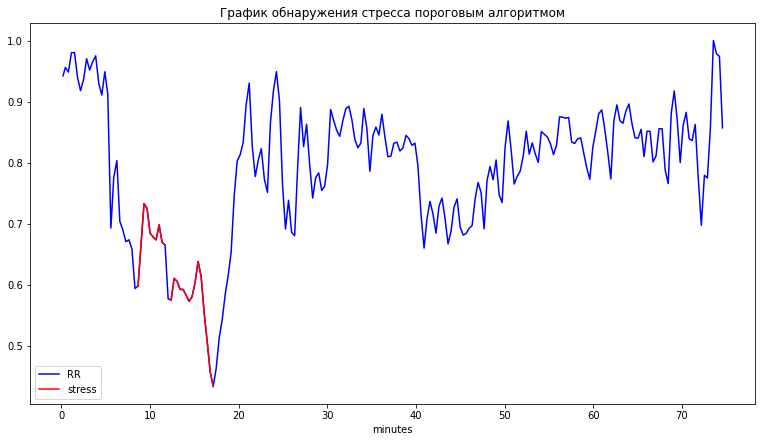

In [162]:
plotReading(input_df, dfpredAlgorithm, "График обнаружения стресса пороговым алгоритмом")

# Проверка на других датасетах

## Функции обработки сигнала

In [402]:
def plotCustomReading(dfnewHRV, dfpred, title = None):
    dfnewHRV["stress"] = dfpred["stress"]
    # dfnewHRV.loc[dfnewHRV["steps"] > 0, 'stress'] = np.nan
    #mark is to mark the RR peaks as stress
    dfnewHRV.loc[dfnewHRV["stress"] == 1, 'stress'] = dfnewHRV['RR'] 
    # dfnewHRV.loc[dfnewHRV["steps"] > 0, 'moving'] = dfnewHRV['interval in seconds'] 
    dfnewHRV["minutes"] = (dfnewHRV['newtime']/60)
    
    from itertools import cycle, islice
    my_colors = list(islice(['b', 'r'], 0, len(dfnewHRV)))
    plot = dfnewHRV.plot(x="minutes", y=['RR',"stress"],color=my_colors,figsize=(13, 7), title = title)

In [530]:
def runAlgorithmCustom(df, selected_x_columns):
  selected_x_columns = [*selected_x_columns, "BSI"]
  df = missing_values(df)
  dfnew = df[selected_x_columns].fillna(0)
  stress = []
  for index, row in dfnew.iterrows():
    s = 0
    if not (60 < row["HR"] < 90): s += 1
    if not (30 < row["BSI"] < 160): s += 1
    if not (568 < row["HF"]*1000 < 768) and (row["HF"] != 0.): s += 0.5
    if not (995 < row["LF"]*1000 < 1345) and (row["LF"] != 0.): s += 0.5
    if not (1077 < row["VLF"]*1000 < 1458) and (row["VLF"] != 0.): s += 0.5
    if not (2640 < row["TP"] * 1E6 < 3571): s += 1
    if not (1.5 < row["LF_HF"] < 1.8) and (row["LF_HF"] != 0.): s += 1
    if s >= 4: stress.append(1)
    else: stress.append(np.nan)
  dfpred = pd.DataFrame(stress, columns = ["stress"])
  return dfpred

## Загрузка и анализ сигнала

In [ ]:
with open(ecg_PX113190529165727) as f:
    ecg = [float(line.strip()) for line in f.readlines()]

In [437]:
import math
fs = 250
sec = 12.5
tot = 75 * 60
w = int(fs*sec)
ecg_part = []
n_w = int(math.ceil(len(ecg) / w))
n_take = round(tot / sec)

In [438]:
ecg_part = [ecg[x:x+w] for x in range(0, n_take * w, w)]

In [471]:
%%capture
params = {key: list() for key in [*selected_x_columns, "newtime", "BSI"]}
selected_x_columns = ['HR','RR','AVNN', 'RMSSD', 'pNN50', 'TP', 'ULF', 'VLF', 'LF', 'HF','LF_HF']
for i, part in enumerate(tqdm(ecg_part)):
  ecg_clean = nk.ecg_clean(part, sampling_rate=fs, method="neurokit")
  peaks, info = nk.ecg_peaks(part, sampling_rate=fs, correct_artifacts=True)
  hrv_time = nk.hrv_time(peaks, sampling_rate=fs, show=False)
  if i > 0 and i % 10 == 0:
    large_part = [el for l in ecg_part[i-10:i] for el in l]
    peaks2, info2 = nk.ecg_peaks(large_part, sampling_rate=fs, correct_artifacts=True)
    hrv_freq2 = nk.hrv_frequency(peaks2, sampling_rate=fs, show=False)
    fdresult2 = fd.welch_psd(rpeaks=info2["ECG_R_Peaks"] / fs)
    params["TP"].append(fdresult2["fft_total"] / 1E6)
    params["ULF"].append(hrv_freq2["HRV_ULF"].values[0])
    params["VLF"].append(hrv_freq2["HRV_VHF"].values[0])
    params["LF"].append(hrv_freq2["HRV_LF"].values[0])
    params["HF"].append(hrv_freq2["HRV_HF"].values[0])
    params["LF_HF"].append(hrv_freq2["HRV_LFHF"].values[0])
    
  ppi = info["ECG_R_Peaks"][1:]
  ppi = np.subtract(ppi, info["ECG_R_Peaks"][:-1])
  ppi = np.array(ppi) / fs 
  rr_max = ppi.max()
  rr_min = ppi.min()
  drr = rr_max - rr_min
  m = stats.mode(ppi)
  Mo, AMo = m[0][0], m[1][0]
  AMo_percent = (AMo / len(ppi))*100
  BSI = round(AMo_percent / (2 * Mo * drr))
  params["HR"].append(60 / hrv_time["HRV_MeanNN"].values[0] * 1000)
  params["RR"].append(Mo)
  params["AVNN"].append(hrv_time["HRV_MeanNN"].values[0] / 1000)
  params["RMSSD"].append(hrv_time["HRV_RMSSD"].values[0] / 1000)
  params["pNN50"].append(hrv_time["HRV_pNN50"].values[0] / 1000)
  params["BSI"].append(BSI)
  params["newtime"].append(i * sec)
params["TP"] = np.resize(np.repeat(params["TP"], 11), len(params["BSI"]))
params["ULF"] = np.resize(np.repeat(params["ULF"], 11), len(params["BSI"]))
params["VLF"] = np.resize(np.repeat(params["VLF"], 11), len(params["BSI"]))
params["LF"] = np.resize(np.repeat(params["LF"], 11), len(params["BSI"]))
params["HF"] = np.resize(np.repeat(params["HF"], 11), len(params["BSI"]))
params["LF_HF"] = np.resize(np.repeat(params["LF_HF"], 11), len(params["BSI"]))

In [472]:
df1 = pd.DataFrame(params)

In [473]:
df1.head()

,HR,RR,AVNN,RMSSD,pNN50,TP,ULF,VLF,LF,HF,LF_HF,newtime,BSI
0,86.642599,0.540,0.692500,0.152543,0.081250,0.018068,NaN,0.01482,0.076531,0.079783,0.959238,0.0,16
1,79.787234,0.524,0.752000,0.196512,0.080000,0.018068,NaN,0.01482,0.076531,0.079783,0.959238,12.5,12
2,91.038915,0.620,0.659059,0.159283,0.082353,0.018068,NaN,0.01482,0.076531,0.079783,0.959238,25.0,41
3,78.479247,0.756,0.764533,0.179574,0.080000,0.018068,NaN,0.01482,0.076531,0.079783,0.959238,37.5,18
4,77.028415,0.624,0.778933,0.320286,0.073333,0.018068,NaN,0.01482,0.076531,0.079783,0.959238,50.0,23


In [492]:
dfpredClassifier = runClassifier(df1, classifier, selected_x_columns)

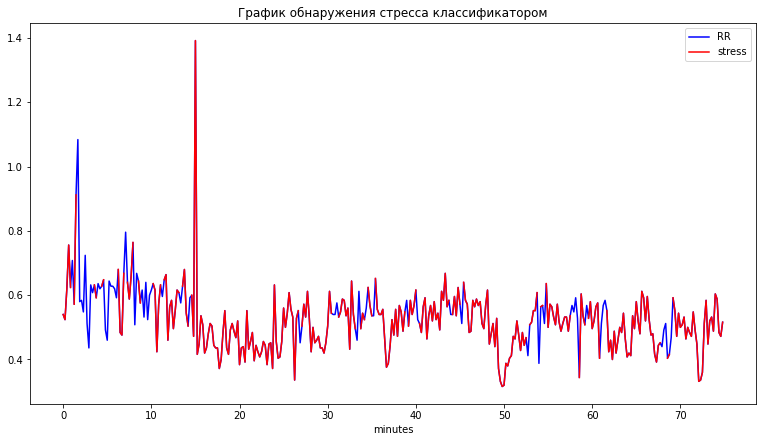

In [493]:
plotCustomReading(df1, dfpredClassifier, "График обнаружения стресса классификатором")

In [528]:
dfpredAlgorithm = runAlgorithmCustom(df1, selected_x_columns)

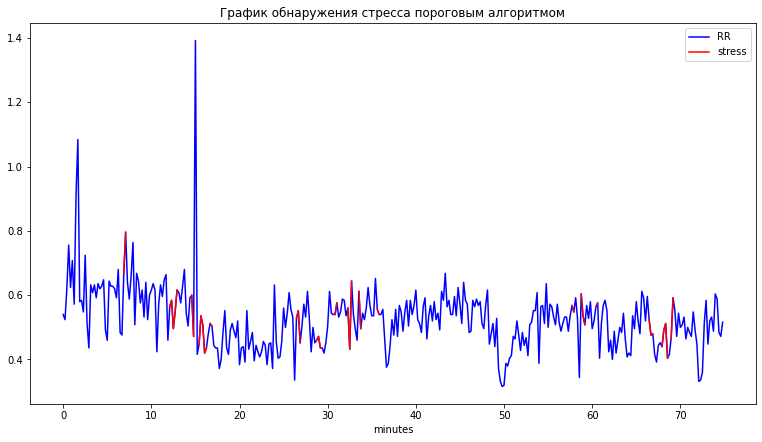

In [531]:
plotCustomReading(df1, dfpredAlgorithm, "График обнаружения стресса пороговым алгоритмом")